# Trajectory View

## Configurations

In [1]:
from sys import stdout

import random
import mdtraj
import nglview
import pandas
import numpy as np
import matplotlib.pyplot as plt

from openmm import *
from tqdm.auto import tqdm
from matplotlib import animation 
from openmm.app import *
from openmm.unit import *
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_dir = "../data"
IMAGE_SIZE = "400px"

## View trajectory

In [8]:
result_dir = "../log"
date = "0814-10:53:40"

molecule = "alanine"
state = "c5"

<Axes: xlabel='#"Time (ps)"'>

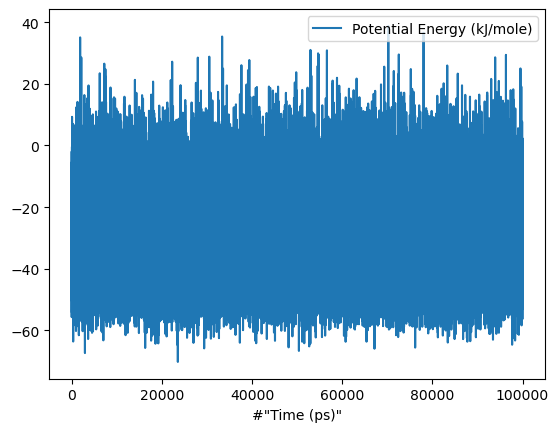

In [4]:
df1 = pandas.read_csv(f"{result_dir}/{date}/scalars.csv")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)")

In [5]:
print("Loading trajectory...")
traj_ad = mdtraj.load(
    f"{result_dir}/{date}/traj.dcd",
    top=f"{data_dir}/alanine/{state}.pdb"
)
print("Showing trajectory...")
traj_ad.superpose(traj_ad, 0)
nglview.show_mdtraj(traj_ad, width=IMAGE_SIZE, height=IMAGE_SIZE)
print("Done...!")

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION

NGLWidget(max_frame=99999999)

In [11]:
def plot_ramachandran(traj, phi_start=None, psi_start=None):
    from matplotlib.gridspec import GridSpec

    phis = mdtraj.compute_phi(traj)[1].ravel()
    psis = mdtraj.compute_psi(traj)[1].ravel()

    fig = plt.figure()
    gs = GridSpec(nrows=3, ncols=3)
    
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, s=20, color="red", zorder=0)
    ax1.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm-LogNorm())
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.scatter(np.arange(len(phis)), phis * 180 / np.pi)
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.scatter(np.arange(len(phis)), psis * 180 / np.pi)
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")

    fig.tight_layout()

state_file = f"{data_dir}/{molecule}/{state}.pdb"
state_traj = mdtraj.load(state_file)
psi_start = mdtraj.compute_psi(state_traj)[1].ravel()[0]
phi_start = mdtraj.compute_phi(state_traj)[1].ravel()[0]

TypeError: unsupported operand type(s) for -: 'function' and 'LogNorm'

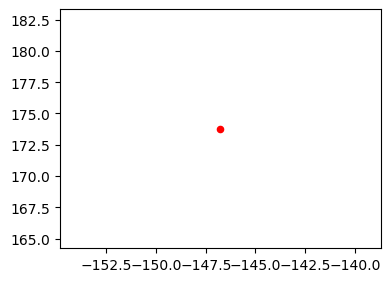

In [12]:
plot_ramachandran(
    traj_ad,
    phi_start = phi_start,
    psi_start = psi_start
)